# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Atacar a la API de Twitter
5. Predecir los nuevos Tweets

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Leemos el dataset

In [2]:
tree = ET.parse('data/general-train-tagged.xml')
root = tree.getroot()

In [3]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


In [6]:
pd.set_option('max_colwidth', None)

In [7]:
df.head()

,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!,2011-12-02T02:59:03,es,P+,AGREEMENT


### Columna de polaridad

In [4]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

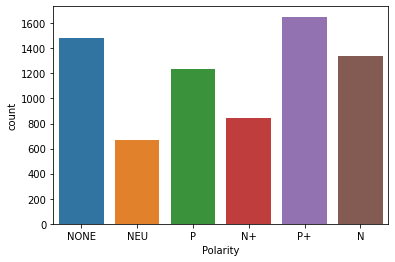

In [8]:
sns.countplot(x = 'Polarity', data=df);

#### Columna de tipo

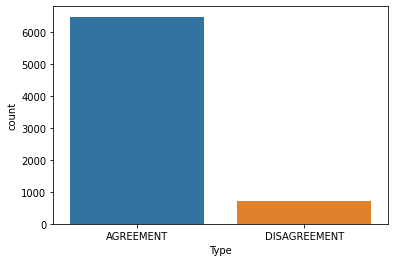

In [9]:
sns.countplot(x = 'Type', data=df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [10]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [11]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [12]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1], dtype=int64)

#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [13]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [14]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

#### Duplicados

In [15]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace=True)
df.shape

(5052, 6)

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [16]:
df['Content'].head()

2                                                                                                                    @marodriguezb Gracias MAR
3           Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)
4                                                                            Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!
6                                                                        Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!
8    Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.
Name: Content, dtype: object

In [17]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

2                                                                                                                  marodriguezb gracias mar
3            off pensando en el regalito sinde la que se va de la sgae cuando se van sus corruptos intento no sacar conclusiones lo intento
4                                                                           conozco a alguien q es adicto al drama ja ja ja te suena d algo
6                                                                            toca crackoviadetv  grabación dl especial navideñomari crismas
8    buen día todos lo primero mandar un abrazo grande a miguel y a su familia libertadmontes hoy podría ser un día para la grandeza humana
Name: Content, dtype: object

#### Eliminamos links

In [18]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [19]:
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

In [20]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [21]:
df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

,User,Content,Date,Lang,Polarity,Type
2,CarmendelRiego,marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT
3,mgilguerrero,off pensando regalito sinde va sgae van corruptos intento sacar conclusiones intento,2011-12-02T02:33:37,es,1,AGREEMENT
4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT
6,Carlos_Latre,toca crackoviadetv grabación dl especial navideñomari crismas,2011-12-02T07:00:50,es,0,AGREEMENT
8,nacho_uriarte,buen día primero mandar abrazo grande miguel familia libertadmontes hoy podría ser día grandeza humana,2011-12-02T07:45:05,es,0,AGREEMENT


#### Stemmer

In [22]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)
df['Content'].head()

2                                                                        marodriguezb graci mar
3                         off pens regalit sind va sga van corrupt intent sac conclusion intent
4                                                     conozc algui q adict dram ja ja ja suen d
6                                    toc crackoviadetv grabacion dl especial navideñomari crism
8    buen dia primer mand abraz grand miguel famili libertadmont hoy podr ser dia grandez human
Name: Content, dtype: object

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [23]:
df = df[['Content', 'Polarity']]

In [24]:
df.to_csv('data/output/data_processed.csv')

#### Vectorizamos el dataset

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

#### Montamos Pipeline
Modelos que suelen funcionar bien con pocas observaciones y muchas features son la Regresión logística el LinearSVC o Naive Bayes.

In [26]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.5, 1 , 1.9),
    'vect__min_df': (5, 10, 20,50),
    'vect__max_features': (500, 1000),
    "cls__penalty": ["l1","l2"], # Regularizaciones L1 y L2.
    "cls__C": [0.1, 0.5, 1.0, 5.0] # Cuanta regularizacion queremos

}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

#### Entrenamos

In [27]:
grid_search.fit(df['Content'], df['Polarity'])

c:\Users\Miguel Angel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Miguel Angel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Miguel Angel\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Miguel Angel\AppData\Local\Prog

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cls__C': [0.1, 0.5, 1.0, 5.0],
                         'cls__penalty': ['l1', 'l2'],
                         'vect__max_df': (0.5, 1, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (5, 10, 20, 50)},
             scoring='accuracy')

In [28]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__C': 0.5, 'cls__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 1000, 'vect__min_df': 5}
Best acc: 0.7513874117382064
Best model: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])


In [29]:
grid_search.best_estimator_['cls']

LogisticRegression(C=0.5)

#### Guardamos el modelo

In [30]:
import pickle

with open('data/output/finished_model.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

## 4. Predicciones
Realizar una predicción con un tweet que escojas

In [31]:
with open('data/output/finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

In [32]:
pipeline_importada

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

#### Leemos el pipeline con el modelo

In [41]:
text = pd.Series('Decepcionando al personal. A quienes parece mal que a Javier Marías y a mí nos gustara mucho John Wayne (en sus películas) podría serles útil esto, escrito hace un par de años.')
test_clean = pd.DataFrame(text, columns=['content'])

# Signos de puntuacion
test_clean['content_clean'] = test_clean['content'].apply(signs_tweets)

# Eliminamos links
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_links)

# Nos cargamos stopwords
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_stopwords)

# Aplicamos el Stemmer
test_clean['content_clean'] = test_clean['content_clean'].apply(spanish_stemmer)

In [42]:
test_clean

,content,content_clean
0,"Decepcionando al personal. A quienes parece mal que a Javier Marías y a mí nos gustara mucho John Wayne (en sus películas) podría serles útil esto, escrito hace un par de años.",decepcion personal parec mal javi mar gust john wayn pelicul podr serl util escrit hac par años


#### Predicciones de test

In [174]:
test_clean['content_clean']

0    bombarde #gernik part aviacion nazi fascist episodi cruent guerr civil años despues record dia tod victim memori imprescind segu constru socied democrat paz
Name: content_clean, dtype: object

In [43]:
predictions = pipeline_importada.predict(test_clean['content_clean'])
test_clean['Polarity'] = pd.Series(predictions)
test_clean

,content,content_clean,Polarity
0,"Decepcionando al personal. A quienes parece mal que a Javier Marías y a mí nos gustara mucho John Wayne (en sus películas) podría serles útil esto, escrito hace un par de años.",decepcion personal parec mal javi mar gust john wayn pelicul podr serl util escrit hac par años,1


In [44]:
predictions = pipeline_importada.predict_proba(test_clean['content_clean'])
test_clean['Polarity_Pos'] = pd.Series(predictions[0][0])
test_clean['Polarity_Neg'] = pd.Series(predictions[0][1])
test_clean

,content,content_clean,Polarity,Polarity_Pos,Polarity_Neg
0,"Decepcionando al personal. A quienes parece mal que a Javier Marías y a mí nos gustara mucho John Wayne (en sus películas) podría serles útil esto, escrito hace un par de años.",decepcion personal parec mal javi mar gust john wayn pelicul podr serl util escrit hac par años,1,0.07601,0.92399
